# 예측 모델 구성 및 SR_02 구현

## 공간적 요소 기반 예측 모델

[3-Stage 모델 성능 (XGBoost + 수요 구간별 모델)]
RMSE  : 20.49
MAE   : 12.60
MAPE  : 41.59%
SMAPE : 33.96%
R²    : 0.761


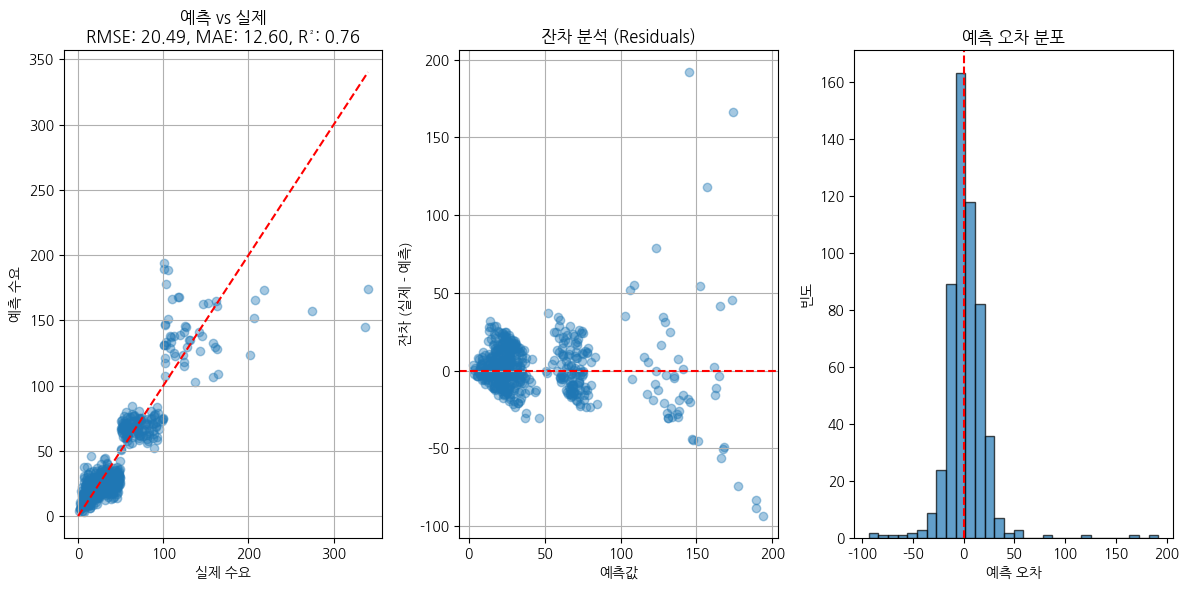


[🚲 실제 테스트 데이터 기반 예시 예측 결과]
선택된 대여소 실제 하루 평균 대여량: 18.90 건
모델이 예측한 하루 평균 대여량: 18.24 건


In [20]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import koreanize_matplotlib
import mysql.connector
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# SMAPE / MAPE 함수 정의
def symmetric_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    smape = np.mean(np.divide(diff, denominator, out=np.zeros_like(diff), where=denominator != 0)) * 100
    return smape

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 데이터 로드
conn = mysql.connector.connect(
    host='jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com',
    port=3306,
    user='root',
    password='jinhyuk2dacibul',
    database='project1'
)
df = pd.read_sql("SELECT * FROM training_set_with_rental", conn)
conn.close()

# Feature 설정
feature_cols = [
    'subway_dist_min', 'subway_usage_avg',
    'bus_dist_min', 'bus_usage_avg',
    'bike_route_count', 'bike_route_length_km',
    'park_count', 'land_area_1000m2',
    'employee_count', 'business_count',
    'employee_density', 'elevation_m',
    'avg_income_krw', 'nearest_station_gap_m'
]

df_filtered = df[df['avg_daily_rental'] > 0].copy()
X = df_filtered[feature_cols]
y = df_filtered['avg_daily_rental']
y_log = np.log1p(y)

# Train/Test Split
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)
y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)

# 수요 구간 설정
def get_demand_bin(y):
    return pd.cut(y, bins=[0, 50, 100, np.inf], labels=['low', 'mid', 'high'])

train_bin = get_demand_bin(y_train)
test_bin = get_demand_bin(y_test)

# Stage 1 모델 학습 (low, mid, high 구간별로)
stage1_model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, random_state=42)
stage1_model.fit(X_train, y_train_log)  # 전체 훈련 데이터로 학습

# Stage 2 모델 학습 (high 구간에 대해서만 학습)
high_demand_mask_train = train_bin == 'high'
X_train_high = X_train[high_demand_mask_train]
y_train_high_log = np.log1p(y_train[high_demand_mask_train])

stage2_model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, random_state=42)
stage2_model.fit(X_train_high, y_train_high_log)

# Stage 3 모델 학습 (고수요 대여소 모델 학습)
model_stage3 = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, random_state=42)
model_stage3.fit(X_train_high, y_train_high_log)

# 구간별 예측 (3단계 예측)
y_pred_final = np.zeros_like(y_test)
for bin_label in ['low', 'mid', 'high']:
    mask = test_bin == bin_label
    X_bin = X_test[mask]
    model = models[bin_label]  # 이미 학습된 모델을 사용

    y_pred_log = model.predict(X_bin)
    y_pred = np.expm1(y_pred_log)
    y_pred_final[mask] = y_pred


# 모델 성능 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae = mean_absolute_error(y_test, y_pred_final)
mape = mean_absolute_percentage_error(y_test, y_pred_final)
smape = symmetric_mape(y_test, y_pred_final)
r2 = r2_score(y_test, y_pred_final)

print("[3-Stage 모델 성능 (XGBoost + 수요 구간별 모델)]")
print(f"RMSE  : {rmse:.2f}")
print(f"MAE   : {mae:.2f}")
print(f"MAPE  : {mape:.2f}%")
print(f"SMAPE : {smape:.2f}%")
print(f"R²    : {r2:.3f}")

# 예측 vs 실제 시각화
plt.figure(figsize=(12, 6))

# 1. 예측값 vs 실제값
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_final, alpha=0.4)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel("실제 수요")
plt.ylabel("예측 수요")
plt.title(f"예측 vs 실제\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
plt.grid(True)

# 2. 잔차 vs 예측값
residuals = y_test - y_pred_final
plt.subplot(1, 3, 2)
plt.scatter(y_pred_final, residuals, alpha=0.4)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("예측값")
plt.ylabel("잔차 (실제 - 예측)")
plt.title("잔차 분석 (Residuals)")
plt.grid(True)

# 3. 잔차 히스토그램
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(0, color='r', linestyle='--')
plt.title("예측 오차 분포")
plt.xlabel("예측 오차")
plt.ylabel("빈도")

plt.tight_layout()
plt.show()

# 실제 테스트용 데이터(X_test, y_test)에서 임의 샘플 추출 및 예측
example_features = X_test.sample(n=1, random_state=53)
example_index = example_features.index[0]
actual_value = y_test.loc[example_index]

# 구간별 모델 예측
example_pred_log_low = models['low'].predict(example_features)  # low 수요 구간 예측
example_pred_log_mid = models['mid'].predict(example_features)  # mid 수요 구간 예측
example_pred_log_high = models['high'].predict(example_features)  # high 수요 구간 예측

# 고수요 판단 후 예측 보정
if example_pred_log_low[0] > 50:  # low 구간에서 threshold를 기준으로 판단
    example_pred_final = np.expm1(example_pred_log_high)  # 고수요 구간 모델 예측
elif example_pred_log_mid[0] > 50:
    example_pred_final = np.expm1(example_pred_log_mid)  # 중간수요 구간 모델 예측
else:
    example_pred_final = np.expm1(example_pred_log_low)  # 저수요 구간 모델 예측

print("\n[🚲 실제 테스트 데이터 기반 예시 예측 결과]")
print(f"선택된 대여소 실제 하루 평균 대여량: {actual_value:.2f} 건")
print(f"모델이 예측한 하루 평균 대여량: {example_pred_final[0]:.2f} 건")

---

### 고수요 대여소가 예측 어려운 구조적 이유
- 비선형적 스케일 효과 (threshold effect)
  - 고수요 대여소는 단순히 "지하철역이 가깝다" 하나만으로 설명되지 않음
  - 특정 feature 조합이 임계치를 넘을 때 수요가 폭발적으로 증가하는 경향이 있음
  - 회귀 모델이 패턴을 포착하기 어려울 수 있음
- 고수요 대여소는 지역 맥락이 특수할 수 있음
  - 서울숲, 여의도공원, 강남역 주변 → 고수요지만 매우 특화된 입지 조건
  - 이건 데이터에 있는 일반적인 feature로는 잘 반영되지 않음 (랜드마크, 관광, 업무 밀집도, 브랜드, 정책 등)

---

# SR_02 구현

In [21]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from xgboost import XGBRegressor
from haversine import haversine
from scipy.spatial import distance_matrix
import mysql.connector

conn = mysql.connector.connect(
    host='jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com',
    port=3306,
    user='root',
    password='jinhyuk2dacibul',
    database='project1'
)

# 등고선과 행정구역 경계 로드
GDF_CONTOUR = gpd.read_file("/home/jinhyuk2me/eda-repo-1/data/서울시 경사도/등고선 5000/N3L_F001.shp").to_crs("EPSG:4326")
GDF_ADMIN = gpd.read_file("/home/jinhyuk2me/eda-repo-1/data/hangjeongdong.geojson").to_crs("EPSG:4326")

# Elevation 계산 함수
def get_elevation_from_contour(lat, lon):
    point = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:4326").to_crs("EPSG:5179").iloc[0]
    contour_proj = GDF_CONTOUR.to_crs("EPSG:5179")
    contour_proj["dist"] = contour_proj.geometry.distance(point)
    nearest = contour_proj.sort_values("dist").iloc[0]
    return nearest['HEIGHT']


# 좌표 → 행정구역 변환 함수
def get_gu_dong_from_coord(lat, lon):
    point = Point(lon, lat)
    match = GDF_ADMIN[GDF_ADMIN.contains(point)]
    if not match.empty:
        row = match.iloc[0]
        return row['sggnm'], row['adm_nm']
    else:
        return None, None

# 교통 접근성 분석 클래스
class TransitAccessibility:
    def __init__(self, lat, lng):
        self.user_lat = lat
        self.user_lng = lng
        self.conn = mysql.connector.connect(
            host="jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
            user="root",
            password="jinhyuk2dacibul",
            database="project1"
        )
        self.cursor = self.conn.cursor()

    def calculate_distance(self, lat1, lng1, lat2, lng2):
        R = 6371
        dlat = np.radians(lat2 - lat1)
        dlng = np.radians(lng2 - lng1)
        a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlng/2)**2
        return R * 2 * np.arcsin(np.sqrt(a))

    def get_closest_station(self, table_name):
        query = f"SELECT * FROM {table_name}"
        self.cursor.execute(query)
        rows = self.cursor.fetchall()
        lat_idx, lng_idx = 5, 4
        return min(rows, key=lambda row: self.calculate_distance(self.user_lat, self.user_lng, float(row[lat_idx]), float(row[lng_idx])))

    def get_subway_avg_flow(self, station_name):
        station_name = station_name.strip().replace("역", "")
        query = f"""
            SELECT * FROM subway_station_hourly_flow
            WHERE subway_station_name = '{station_name}'
              AND subway_line IN ('1호선','2호선','3호선','4호선','5호선','6호선','7호선','8호선','9호선')
        """
        df = pd.read_sql(query, self.conn)
        if df.empty:
            return 0
        total = df[[c for c in df.columns if c.startswith("boarding_") or c.startswith("alighting_")]].sum().sum()
        return int((total / len(df)) / 366)

    def get_bus_avg_flow(self, station_id):
        query = f"SELECT * FROM bus_station_hourly_timeflow WHERE bus_station_id = '{station_id}'"
        df = pd.read_sql(query, self.conn)
        if df.empty:
            return 0
        total = 0
        for h in [f"{i:02}" for i in range(24)]:
            total += df[f"boarding_{h}"].sum() + df[f"alighting_{h}"].sum()
        return int((total / len(df)) / 366)

    def analyze(self):
        subway_row = self.get_closest_station("subway_station_location")
        subway_dist = self.calculate_distance(self.user_lat, self.user_lng, float(subway_row[5]), float(subway_row[4]))
        subway_avg = self.get_subway_avg_flow(subway_row[1])

        bus_row = self.get_closest_station("bus_station_location")
        bus_dist = self.calculate_distance(self.user_lat, self.user_lng, float(bus_row[5]), float(bus_row[4]))
        bus_avg = self.get_bus_avg_flow(bus_row[0])

        return round(subway_dist, 3), subway_avg, round(bus_dist, 3), bus_avg

# 후보지 생성
def generate_candidate_grid(lat_min, lon_min, lat_max, lon_max, grid_spacing=0.001):
    lat_range = np.arange(lat_min, lat_max, grid_spacing)
    lon_range = np.arange(lon_min, lon_max, grid_spacing)
    return pd.DataFrame([{'lat': lat, 'lon': lon} for lat in lat_range for lon in lon_range])

# 거리 기반 필터링
def filter_candidates_by_distance(candidates_df, existing_stations_df, min_distance_m=200):
    filtered = []
    for _, candidate in candidates_df.iterrows():
        cand_coord = (candidate['lat'], candidate['lon'])
        distances = existing_stations_df.apply(lambda row: haversine(cand_coord, (row['lat'], row['lon'])) * 1000, axis=1)
        if distances.min() >= min_distance_m:
            filtered.append(candidate)
    return pd.DataFrame(filtered)

# Feature 생성
def generate_features_for_candidates(candidates_df):
    conn = mysql.connector.connect(
        host="jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
        user="root",
        password="jinhyuk2dacibul",
        database="project1"
    )
    features = []
    for _, row in candidates_df.iterrows():
        lat, lon = row['lat'], row['lon']
        ta = TransitAccessibility(lat, lon)
        subway_dist, subway_avg, bus_dist, bus_avg = ta.analyze()
        gu_name, dong_name = get_gu_dong_from_coord(lat, lon)
        elevation = get_elevation_from_contour(lat, lon)

        features.append({
            'lat': lat,
            'lon': lon,
            'gu_name': gu_name,
            'dong_name': dong_name,
            'subway_dist_min': subway_dist * 1000,
            'subway_usage_avg': subway_avg,
            'bus_dist_min': bus_dist * 1000,
            'bus_usage_avg': bus_avg,
            'elevation_m': elevation
        })

    df = pd.DataFrame(features)

    gu_df = pd.read_sql("SELECT * FROM park_bikeroad_gu", conn).rename(columns={
        "total_routes": "bike_route_count",
        "total_length_km": "bike_route_length_km",
        "num_parks": "park_count",
        "total_area_1000m2": "land_area_1000m2"  # ✅ 추가된 부분
    })

    df = df.merge(gu_df, on="gu_name", how="left")

    income_df = pd.read_sql("SELECT dong_name, avg_income FROM income_avg_dong", conn)
    df = df.merge(income_df.rename(columns={"avg_income": "avg_income_krw"}), on="dong_name", how="left")

    emp_df = pd.read_sql("""
        SELECT dong_name, num_employees, num_businesses, employee_density
        FROM employment_dong
    """, conn).rename(columns={
        "num_employees": "employee_count",
        "num_businesses": "business_count"
    })
    df = df.merge(emp_df, on="dong_name", how="left")

    coords = df[['lat', 'lon']].values
    dist_mtx = distance_matrix(coords, coords) * 1000
    np.fill_diagonal(dist_mtx, np.inf)
    df['nearest_station_gap_m'] = dist_mtx.min(axis=1)

    return df

def recommend_optimal_locations_3stage(
    lat_min, lon_min, lat_max, lon_max,
    existing_stations_df, stage1_model, stage2_model, stage3_model,
    feature_cols, thresholds,
    min_distance_m=200, top_n=5
):
    """
    지정된 영역 내에서 추천 위치 후보를 생성하고,
    수요 예측 결과를 바탕으로 상위 후보지를 반환 (3-Stage 방식).
    """

    # 1. 후보지 격자 생성
    candidates = generate_candidate_grid(lat_min, lon_min, lat_max, lon_max)

    # 2. 기존 대여소와 거리 기반 필터링
    filtered_candidates = filter_candidates_by_distance(candidates, existing_stations_df, min_distance_m)

    # 3. Feature 생성
    candidates_with_features = generate_features_for_candidates(filtered_candidates)

    # 4. Stage 1 → Stage 2 → Stage 3 수요 예측
    X_candidates = candidates_with_features[feature_cols]

    # Stage 1 예측
    y_pred_stage1_log = stage1_model.predict(X_candidates)
    candidates_with_features["predicted_demand_stage1"] = np.expm1(y_pred_stage1_log)

    # Stage 2 예측
    high_demand_mask_stage1 = candidates_with_features["predicted_demand_stage1"] > thresholds['stage1']
    X_high_stage1 = X_candidates[high_demand_mask_stage1]
    if not X_high_stage1.empty:
        y_pred_stage2_log = stage2_model.predict(X_high_stage1)
        candidates_with_features.loc[high_demand_mask_stage1, "predicted_demand_stage2"] = np.expm1(y_pred_stage2_log)
    else:
        candidates_with_features["predicted_demand_stage2"] = np.nan  # 예측 값이 없으면 NaN으로 처리

    # Stage 3 예측
    high_demand_mask_stage2 = candidates_with_features["predicted_demand_stage2"] > thresholds['stage2']
    X_high_stage2 = X_candidates[high_demand_mask_stage2]
    if not X_high_stage2.empty:
        y_pred_stage3_log = stage3_model.predict(X_high_stage2)
        candidates_with_features.loc[high_demand_mask_stage2, "predicted_demand_stage3"] = np.expm1(y_pred_stage3_log)
    else:
        candidates_with_features["predicted_demand_stage3"] = np.nan  # 예측 값이 없으면 NaN으로 처리

    # 예측값이 없으면 stage1 예측값을 사용하도록 처리
    candidates_with_features['predicted_demand_final'] = candidates_with_features[['predicted_demand_stage3', 'predicted_demand_stage2', 'predicted_demand_stage1']].max(axis=1, skipna=True)

    # 5. 수요 기준 상위 후보 추천
    recommended = candidates_with_features.sort_values("predicted_demand_final", ascending=False).head(top_n)

    return recommended[['lat', 'lon', 'predicted_demand_final']]


# 기존 대여소 위치 정보 (위도/경도만 추출)
existing_stations_df = pd.read_sql("""
    SELECT station_latitude AS lat, station_longitude AS lon
    FROM station
    WHERE station_latitude IS NOT NULL AND station_longitude IS NOT NULL
""", conn)

recommended = recommend_optimal_locations_3stage(
    lat_min=37.5600, lon_min=126.9700,
    lat_max=37.5700, lon_max=126.9800,
    existing_stations_df=existing_stations_df,
    stage1_model=stage1_model,
    stage2_model=stage2_model,
    stage3_model=model_stage3,
    feature_cols=feature_cols,
    thresholds={'stage1': 50, 'stage2': 100}, 
    min_distance_m=200,
    top_n=3
)

In [19]:
print(recommended)

      lat      lon  predicted_demand_final
1  37.561  126.978               27.851952
2  37.562  126.977               27.025442
3  37.562  126.978               19.727177


In [27]:
import folium
from folium.plugins import MarkerCluster

# 1. 지도 중심을 추천 후보지 첫 지점 or 고정값으로 설정
if not recommended.empty:
    center_lat = recommended.iloc[0]['lat']
    center_lon = recommended.iloc[0]['lon']
else:
    center_lat, center_lon = 37.5655, 126.9750  # 종각 근처

m = folium.Map(location=[center_lat, center_lon], zoom_start=17)
# 2. 기존 대여소 마커 (파란색)
existing_cluster = MarkerCluster(name="기존 대여소").add_to(m)
for _, row in existing_stations_df.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        icon=folium.Icon(color='blue', icon='bicycle', prefix='fa'),
        tooltip='기존 대여소'
    ).add_to(existing_cluster)

# 3. 추천 위치 마커 (빨간색)
recommend_cluster = MarkerCluster(name="추천 위치").add_to(m)
for _, row in recommended.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        icon=folium.Icon(color='red', icon='star', prefix='fa'),
        tooltip=f"예상 수요: {row['predicted_demand_final']:.1f}건"
    ).add_to(recommend_cluster)

# 6. 지도 출력
m
